# Final Project Problem 2

This is a repeat of a previous problem but with periodic boundary conditions rather than vacuum. This seems slightly ambiguous, since it seems like in the naive implementation, there are an infinite number of "ghost cells" (you can keep looking further and further in one direction, and hit the same particle an infinite number of times). Obviously, one can't brute force this (without implementing some kind of cutoff or simliar). Instead, from looking online, it seems like the most common approach is to apply the 'minimum image convention', where, for each particle, you only calculate its force on a given particle from either it or its image that is closest to the particle in question. It's actually very simple to implement this in my existing code. I already parameterized the brute-force iterations in terms of the cardinal directions. This is actually a relatively simple change. All we need to do is check if the distance between particles in each cardinal direction is larger than half the box size. If so, then its image on the other side of the box will be "closer" in that cardinal direction. We repeat this for each cardinal direction, and we will have found the particle (or associated image) closest to a given source. In practice, we only need to add 3 lines of code to my previous implementation - nice!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

In [2]:
seed = 5008 

def set_intitial_conditions(N):
    '''
    Set initial particle conditions as a random int from 0 to 100 along each axis.
    '''
    np.random.seed(seed) # reseed the initial conditions for reproducibility
    x = np.random.uniform(0, 100, N)
    y = np.random.uniform(0, 100, N)
    z = np.random.uniform(0, 100, N)
    return x, y, z

In [ ]:
# I use the numba python package, which compiles code JIT (at runtime)
# to speed up the runs. The scaling of the acceleration function should
# not be changed by this, since the operations grow with the same time
# complexity, but it makes the total runtime more manageable
@numba.njit
def acceleration(x, y, z, box_size=100):
    '''
    Acceleration of each particle using the brute-force method (direct)
    '''
    # empty arrays for acceleration of each particle
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)

    # calculate the distance between each pair of particles
    for i in range(len(x)):
        # we can save some calculations by noting that the distance between particles
        # i and j is the same as between j and i. So only need to iterate over half of the pairs
        for j in range(i + 1, len(x)):
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]

            '''
            HERE IS THE START OF THE NEW CODE
            '''

            # APPLY MINIMUM IMAGE CONVENTION
            dx = dx - box_size * np.round(dx / box_size)
            dy = dy - box_size * np.round(dy / box_size)
            dz = dz - box_size * np.round(dz / box_size)

            '''
            END OF THE NEW CODE - THAT'S REALLY IT!
            '''

            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r == 0:
                continue # each particle has no acceleration on itself
            a = 1 / r**2 # assuming GM = 1

            # add the acceleration of i on j
            ax[i] += a * dx / r
            ay[i] += a * dy / r
            az[i] += a * dz / r

            # to use the trick above, we need to add the acceleration of j on i
            ax[j] -= a * dx / r 
            ay[j] -= a * dy / r
            az[j] -= a * dz / r
    
    return ax, ay, az

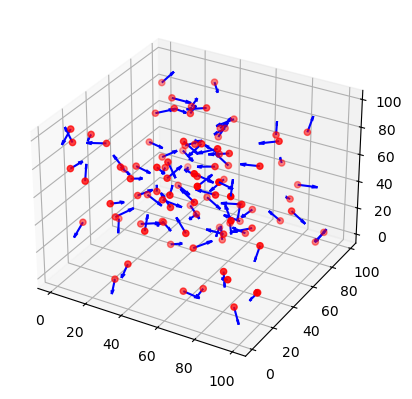

In [4]:
# for fun, a 3d scatter plot with arrows for the acceleration of each particle
# to visualize what we're computing in this problem

x, y, z = set_intitial_conditions(100) # generate 100 random particles
ax, ay, az = acceleration(x, y, z, box_size=100) # calculate their accelerations

# plot the points in 3d
fig = plt.figure()
axi = fig.add_subplot(111, projection='3d')
axi.scatter(x, y, z, c='r', marker='o')

# plot the acceleration of each particle
for i in range(len(x)):
    plt.quiver(x[i], y[i], z[i], ax[i], ay[i], az[i], length=10, normalize=True, color='b')

Compared to the original version, where the arrows all naturally pointed towards the center, they look a lot more anisotropic here (as expected).

In [5]:


ts_brute = [] # store the times for the direct method

# time the acceleration function using the brute-force and KDtree methods
Ns = [100000]
for N in Ns:
    # set up the initial conditions
    x, y, z = set_intitial_conditions(N)

    # run and time the direct method
    start = time.time()
    ax, ay, az = acceleration(x, y, z, box_size=100)
    end = time.time()

    ts_brute.append(end - start)
    print("Brute-force: ", end - start)

Brute-force:  26.754706144332886


Success! To check if I actually implemented this convention correctly, I do a quick test comparing the x-acceleration vs x-position of each particle. For the peridic boundary condition case, since the particles are distributed randomly in the box, we essentially have an infinite, homogeneous universe. As a result, the accelerations should be completely anisotropic and have no relation on the x position.

(-30.0, 30.0)

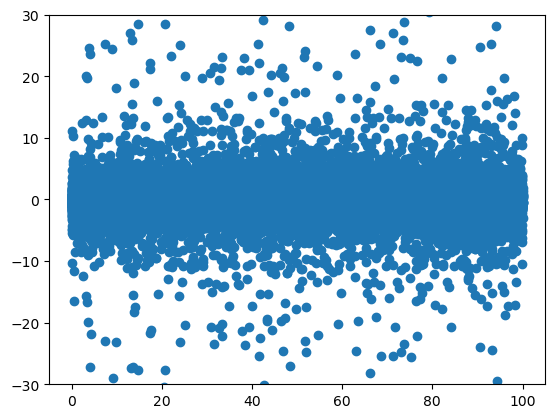

In [6]:
plt.scatter(x, ax)
plt.ylim(-30, 30)

And that's exactly what we see. As a contrast check, we can plot the same thing for the original (vacuum boundary conditions) version

In [7]:
# I use the numba python package, which compiles code JIT (at runtime)
# to speed up the runs. The scaling of the acceleration function should
# not be changed by this, since the operations grow with the same time
# complexity, but it makes the total runtime more manageable
@numba.njit
def acceleration(x, y, z):
    '''
    Acceleration of each particle using the brute-force method (direct)
    '''
    # empty arrays for acceleration of each particle
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)

    # calculate the distance between each pair of particles
    for i in range(len(x)):
        # we can save some calculations by noting that the distance between particles
        # i and j is the same as between j and i. So only need to iterate over half of the pairs
        for j in range(i + 1, len(x)):
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r == 0:
                continue # each particle has no acceleration on itself
            a = 1 / r**2 # assuming GM = 1

            # add the acceleration of i on j
            ax[i] += a * dx / r
            ay[i] += a * dy / r
            az[i] += a * dz / r

            # to use the trick above, we need to add the acceleration of j on i
            ax[j] -= a * dx / r 
            ay[j] -= a * dy / r
            az[j] -= a * dz / r
    
    return ax, ay, az

In [8]:
import time

ts_brute = [] # store the times for the direct method

# time the acceleration function using the brute-force and KDtree methods
Ns = [100000]
for N in Ns:
    # set up the initial conditions
    x, y, z = set_intitial_conditions(N)

    # run and time the direct method
    start = time.time()
    ax, ay, az = acceleration(x, y, z)
    end = time.time()

    ts_brute.append(end - start)
    print("Brute-force: ", end - start)

Brute-force:  21.105578899383545


(-30.0, 30.0)

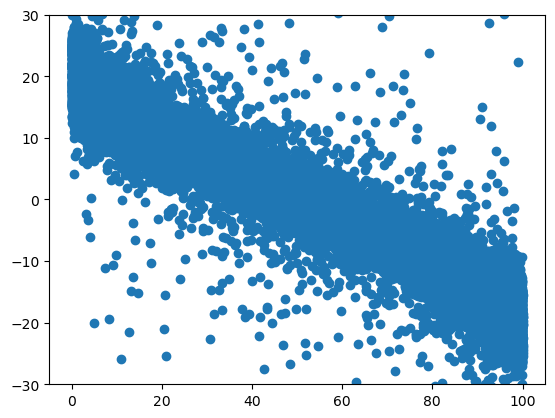

In [9]:
plt.scatter(x, ax)
plt.ylim(-30, 30)

With vacuum boundary conditions, we should expect all of the accelerations to generally point inwards. Particles towards the center will have roughly isotropic accelerations (they 'see' particles all around them). On the other hand, particles far away from the center 'see' a concentration towards the center of the box. As a result, the accelerations should point roughly towards the center, and that's exactly what we observe in this plot. Thus, that gives confidence the to accuracy of the minimum image convention implmentation.

The last part of this problem is to try to think about how one could do this with a KDTree. I imagine that somehow, one could do this by changing how the tree is connected. Instead of having this as a purely hierarchical tree, one might need to set it up as a more connected graph, where the organization of the tree is different because you no longer have associativity between node distances. For example, particle A might be closest to the actual particle B. And particle B might be closest to actual particle B. However, particle A might actually be closest to an *image* of C, not its actual particle. So here, changing the connection structure might be the best approach. In particular, nodes might be connected directly if they are closer to each others' images rather than particles themselves, whereas more normal hierarchical connections might indicate particle-particle pairs (not particle-image).